<a href="https://colab.research.google.com/github/astrodatos/proyecto_neuralclusters/blob/master/Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
!pip install --pre --quiet astroquery

     |████████████████████████████████| 4.3MB 4.9MB/s 
     |████████████████████████████████| 61kB 23.6MB/s 
     |████████████████████████████████| 2.3MB 47.0MB/s 
     |████████████████████████████████| 102kB 34.6MB/s 


In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Get the data
First download the dataset.-

In [0]:
data = SDSS.query_sql("""SELECT TOP 1000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z,s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO' AND s.class !='GALAXY'
                      
                      """)

In [255]:
datapd=data.to_pandas()
print(datapd)

     fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0      21.52917    19.09319    18.01462    17.60681    17.33898        4382
1      20.24847    18.08948    17.24210    16.94940    16.77840        4775
2      20.50707    17.88780    16.45028    15.62309    15.15278        3980
3      19.21585    18.29644    18.04498    17.95963    17.87761        6500
4      20.53941    18.63273    17.78938    17.43530    17.19667        4576
5      20.32361    18.34216    17.48170    17.17563    16.96933        4576
6      20.93198    18.45241    17.39100    17.02799    16.80039        4246
7      17.93577    16.81591    16.34029    16.17065    16.06013        5651
8      20.64200    18.28629    16.88792    15.63043    14.94003        3717
9      19.17190    17.14279    16.31588    15.93594    15.67325        4775
10     19.76383    18.05365    17.33277    17.02597    16.81081        5059
11     21.76395    19.24544    17.81715    16.86257    16.31493        3717
12     17.97

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)


### Inspect the data

Look at the overall statistics:

In [257]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,800.0,20.156985,1.801771,15.83426,18.877605,19.957505,21.242758,25.68168
fiberMag_g,800.0,18.807970,1.572446,15.04047,17.708652,18.776555,19.666522,25.22467
fiberMag_r,800.0,18.276944,1.415362,14.88521,17.251848,18.235475,19.205043,23.28613
fiberMag_i,800.0,17.978168,1.326786,14.74759,17.033437,17.909590,19.018313,21.92784
fiberMag_z,800.0,17.826347,1.371608,14.69162,16.825660,17.762530,18.767578,22.22213


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd




### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [0]:
#norm train label
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [260]:

#normtest_temp=tf.keras.utils.normalize(test_labels,axis=0)
train_mean=train_labels.mean()
train_std=train_labels.std()


norm_train_labels=(train_labels-train_mean)/train_std
norm_train_feat = (train_feat - train_feat.mean())/train_feat.std()
print(norm_trainlabels)

993    0.370217
859   -0.592766
298   -0.502389
553    0.058572
672   -0.365265
971    0.370217
27    -0.089771
231    0.993508
306    0.058572
706    0.993508
496   -1.364400
558   -0.949912
784   -0.564718
239    0.370217
578   -1.034680
55     1.928444
906    0.370217
175   -0.249333
14    -0.365265
77     0.993508
31    -0.268032
481   -1.364400
310   -0.009366
311    0.058572
883    1.212906
788   -1.200475
45     0.058572
103   -1.200475
760   -1.200475
1     -0.704959
         ...   
216   -0.268032
735   -1.364400
129   -0.387081
349    0.613301
111   -0.387081
166    0.993508
207   -0.527944
438    1.928444
552   -0.828994
274    0.993508
974   -0.158956
591    0.681863
800   -0.592766
937    1.088248
525   -1.364400
287   -1.364400
469   -1.371880
326   -1.364400
121   -0.535424
994    0.058572
507   -1.276516
228   -0.273642
673    1.212906
595    0.484903
445   -0.158956
117    1.928444
464   -1.364400
25    -0.020586
110   -0.150230
149   -0.828994
Name: elodieTEff, Length

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.



## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(1, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    #layers.Dense(4, activation=tf.nn.relu),
    #layers.Dense(4, activation=tf.nn.relu),
    #layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [262]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [263]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the `history` object.

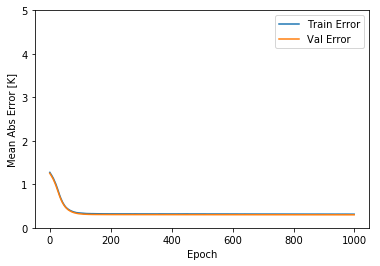

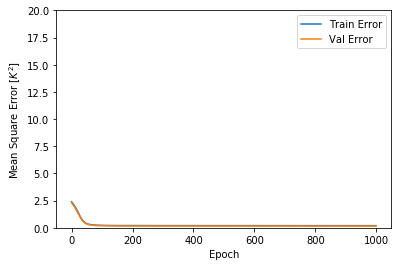

In [264]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [0]:
#model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history = model.fit(norm_train_feat, train_labels, epochs=EPOCHS,
#                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
#print(history)
#plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [266]:
norm_test_feat = (test_feat-test_feat.mean())/test_feat.std()
norm_test_labels = (test_labels-test_labels.mean())/test_labels.std()


loss, mae, mse = model.evaluate(norm_test_feat, norm_test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Kelvin".format(mae))

Testing set Mean Abs Error:  0.32 Kelvin


### Make predictions

Finally, predict Temperature values using data in the testing set:

(-1.6329514117947306,
 2.613090317684287,
 -1.1151214899869417,
 3.1309202394920757)

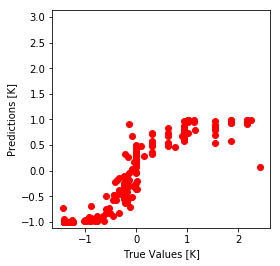

In [267]:
#print(norm_test_labels)

test_predictions = model.predict(norm_test_feat).flatten()
#test_predictions = model.predict(norm_test_feat)
#print(test_predictions)

plt.scatter(norm_test_labels, test_predictions, color='red')
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

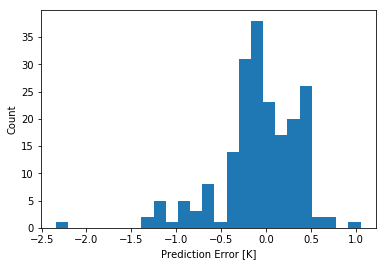

In [268]:
error = test_predictions - norm_test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.



## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.
